In [6]:
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Laser Shooting Strategy 1

**Overview**
1. Find target position from image by using meter/pixel approximation from ar tags
2. Calculate angle to turn from target position using Trigonometry
3. Use result angle to turn astrobee

## Target position

In [140]:
# CONSTANT
cam_mat = np.array(
    [
        [523.105750, 0.000000, 635.434258],
        [0.000000, 534.765913, 500.335102],
        [0.000000, 0.000000, 1.000000],
    ]
)
dist_coeffs = np.array([-0.164787, 0.020375, -0.001572, -0.000369, 0.000000])

### 1. Find target position on image
From this post [undistort-vs-undistortpoints-for-feature-matching-of-calibrated-images](https://stackoverflow.com/questions/30919957/undistort-vs-undistortpoints-for-feature-matching-of-calibrated-images) \
We should use `undistort` instead of `undistortPoint`

[opencv-undistort-cropped-image](https://stackoverflow.com/questions/68634072/opencv-undistort-cropped-image), this post tell how to undistort cropped image by using new principal point

In [121]:
def undistort_cropped(img, x: int, y: int):
    tcam_mat = np.array(
        [
            [523.105750, 0.000000, 635.434258 - x],
            [0.000000, 534.765913, 500.335102 - y],
            [0.000000, 0.000000, 1.000000],
        ]
    )
    res = cv2.undistort(img, tcam_mat, dist_coeffs)
    return res

In [122]:
# Image processing
crop_x = 500
crop_y = 500

img = cv2.imread(
    "../../Img/target2.png", cv2.IMREAD_GRAYSCALE
)  # reading image == api.getMatNavCam()
c_img = img[crop_y:700, crop_x:830].copy()  # cropped image (y:y+height, x:x+width)
ud_img = undistort_cropped(c_img, crop_x, crop_y)

In [123]:
# Finding circle
circle = cv2.HoughCircles(
    ud_img, cv2.HOUGH_GRADIENT, 1, 300, param1=50, param2=30, minRadius=40, maxRadius=50
)
center = circle[0][0]
center

array([172.5, 103.5,  45.4], dtype=float32)

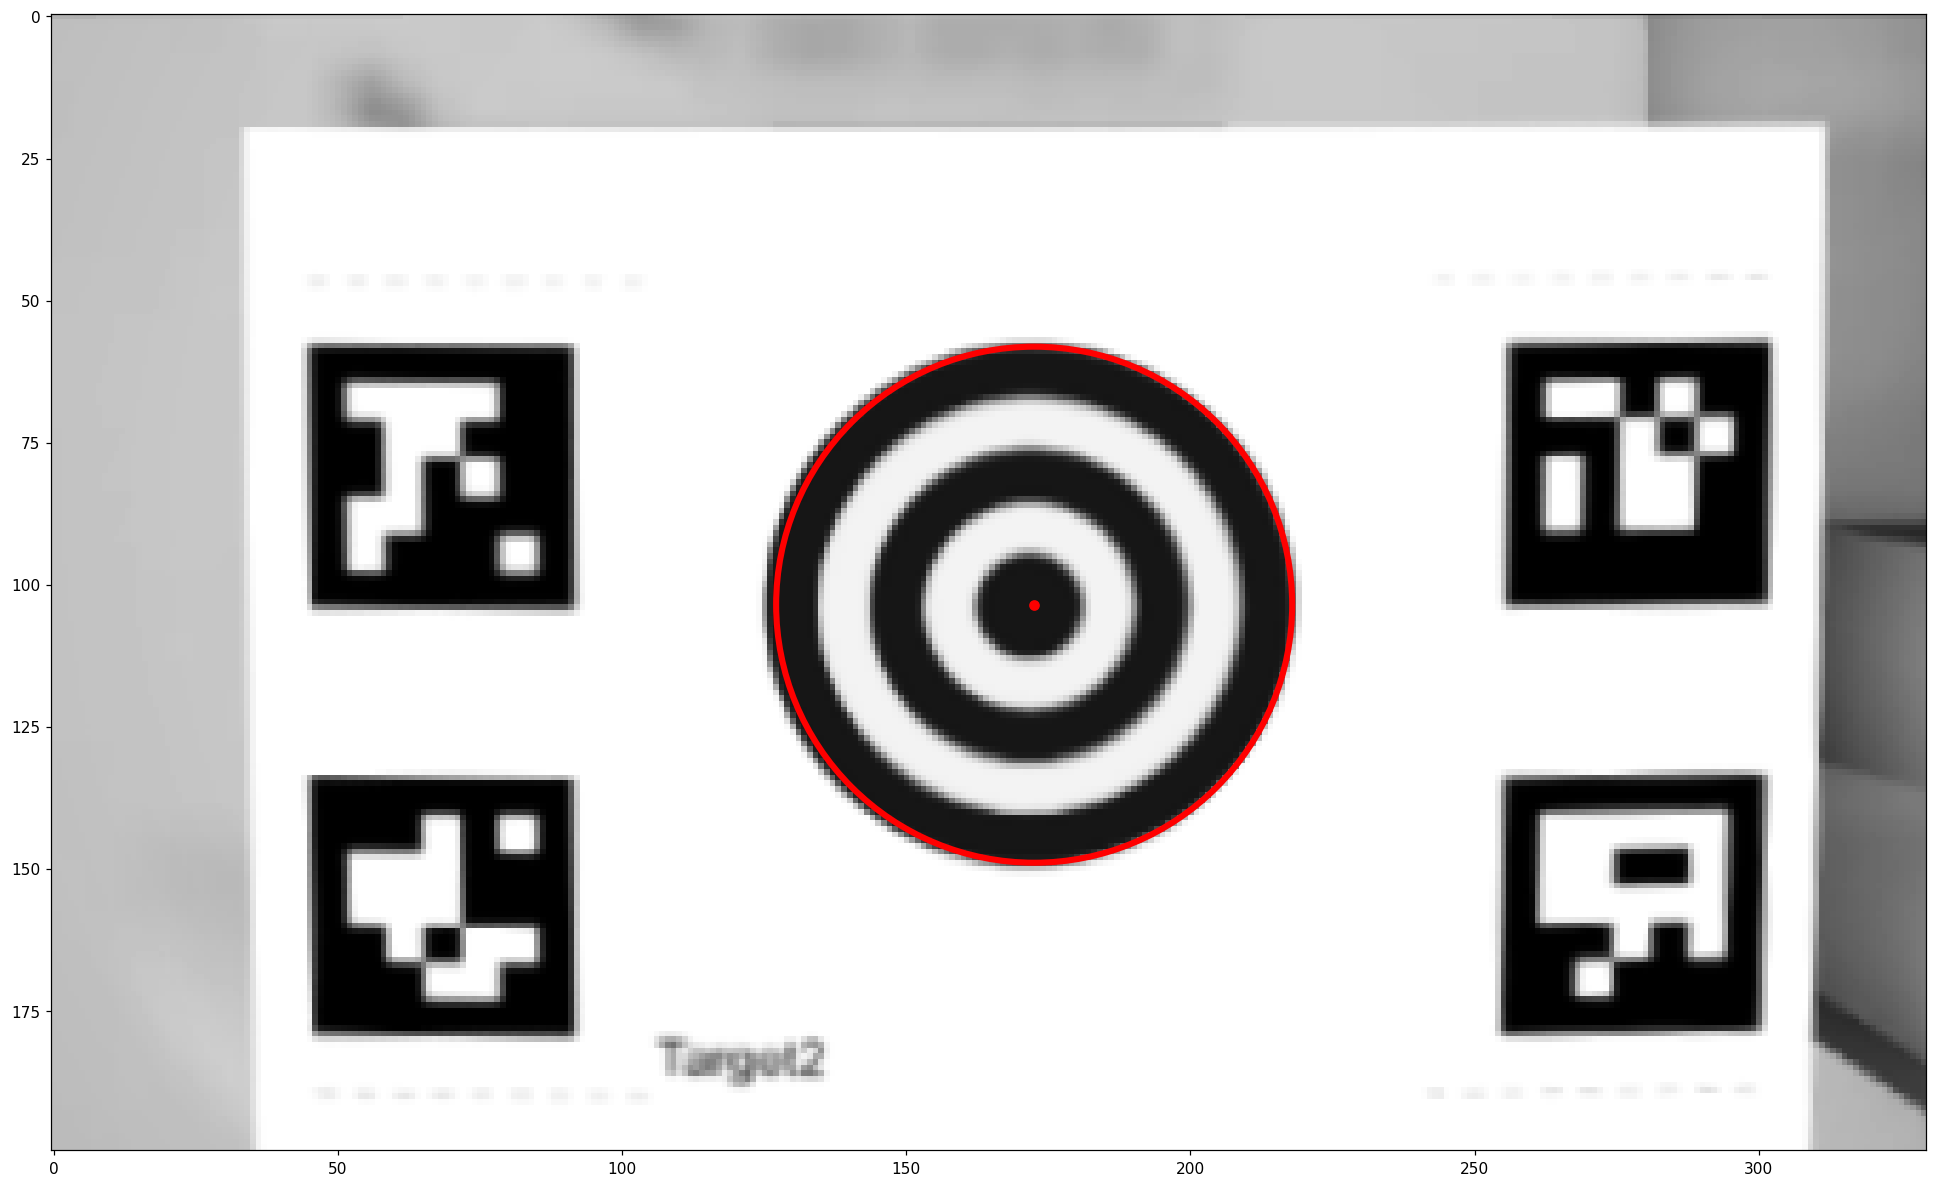

In [124]:
# Show Image
fig = plt.figure(figsize=(22, 22), dpi=110)
ax = fig.add_subplot()
ax.scatter(center[0], center[1], c="red")
ax.imshow(ud_img, cmap="gray")
# add circle patch to ax
circle = plt.Circle(center[:2], center[2], fill=False, edgecolor="red", lw=4)
ax.add_patch(circle)

In [125]:
#
center[0] += crop_x
center[1] += crop_y
center

array([672.5, 603.5,  45.4], dtype=float32)

### 2. Calculate world position using meter/pixel aprroximation

#### Use meter/pixel approximation
AR tag in realworld is 0.05 m width and height so we use this information to calculate $C$ (meter/pixel constant) \
$C$ (meter/pixel) $= \frac{0.05}{\text{s_len}}$

In [134]:
# reading AR tag
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
corners, ids, _ = cv2.aruco.detectMarkers(
    ud_img, aruco_dict
)  # using the same image from above

In [135]:
# calculate average size of AR tag
s_len = 0
for i in range(len(corners)):
    c = corners[i][0]
    s1 = distance(c[0][0], c[0][1], c[1][0], c[1][1])
    s2 = distance(c[1][0], c[1][1], c[2][0], c[2][1])
    s3 = distance(c[2][0], c[2][1], c[3][0], c[3][1])
    s4 = distance(c[3][0], c[3][1], c[0][0], c[0][1])
    s_avg = sum([s1, s2, s3, s4]) / 4
    s_len += s_avg

s_len /= 4
s_len

45.25975353391218

In [136]:
# calculate meter/pixel
meter_px = 0.05 / s_len
meter_px

0.001104734252751422

Calculating world cordinate by using difference from camera center

In [137]:
cx, cy = 635.434258, 500.335102  # this is from camera matrix
xdist = center[0] - cx
ydist = center[1] - cy
xdist, ydist

(37.065742, 103.164898)

In [138]:
# convert to meter
xdist *= meter_px
ydist *= meter_px
# target distance
target_dist = abs(
    -10.581 - (-9.922840 - 0.1177)
)  # target_y - (astrobee_pos + navcam_offset)
target_dist

xdist, ydist, target_dist

(0.040947794791047, 0.11396979650220666, 0.5404599999999995)

In [139]:
# subtract nav cam offset
xc = xdist - 0.0422
yc = -ydist + 0.0826
xc, yc

(-0.001252205208953, -0.03136979650220666)

## Calulate angle to turn

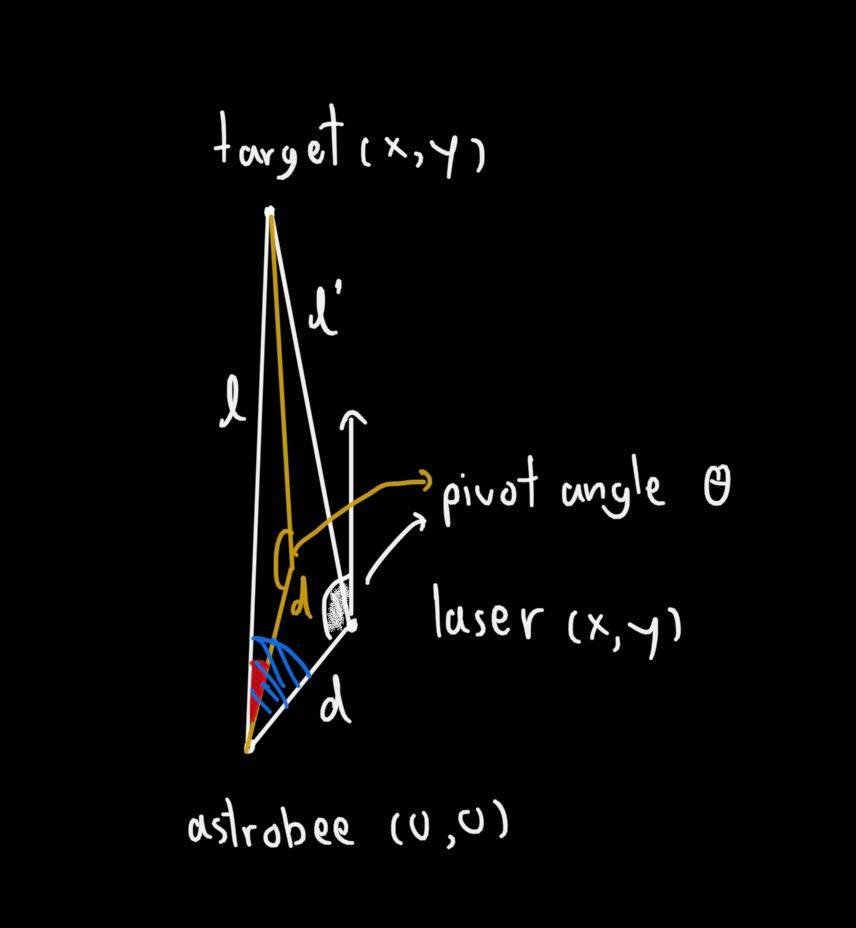

$\text{angle1} = \text{blue angle}$ \
$\text{angle2} = \text{red angle}$

What we need is $\text{angle1} - \text{angle2}$

In [156]:
t_l = abs(-10.581 - (-9.922840))  # target_y - (astrobee_pos + navcam_offset)
t_l

0.6581599999999987

#### YZ plane

In [157]:
pivot_angle = math.atan(0.1302 / 0.1111) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.435184375290124, 139.52578704032607)

In [158]:
d = math.sqrt(0.1302**2 + 0.1111**2)
l = math.sqrt(t_l**2 + yc**2)
l_p = math.sqrt((t_l - 0.1302) ** 2 + (yc - 0.1111) ** 2)
l, d, l_p

(0.6589071632123816, 0.1711585522257068, 0.5468449547315755)

In [159]:
angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
angle2 = math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)

angle1, angle2, angle1 - angle2

(0.7540351077270114, 0.536986408815324, 0.21704869891168743)

In [160]:
turn_angle = angle1 - angle2
print(f"∠x : {turn_angle} , {math.degrees(turn_angle)}°")

∠x : 0.21704869891168743 , 12.435974396445435°


#### XY plane

In [161]:
pivot_angle = math.atan(0.1302 / 0.0572) + math.radians(90)
pivot_angle, math.degrees(pivot_angle)

(2.727652176143348, 156.28295767268844)

In [162]:
d = math.sqrt(0.0572**2 + 0.1302**2)
l = math.sqrt((xc) ** 2 + t_l**2)
l_p = math.sqrt((xc - 0.0572) ** 2 + (t_l - 0.1302) ** 2)
l, d, l_p

(0.6581611912122164, 0.14221068876846074, 0.5311858637932567)

In [163]:
angle1 = math.acos((d**2 + l**2 - l_p**2) / (2 * d * l))
angle2 = math.radians(180) - pivot_angle - math.asin((d * math.sin(pivot_angle)) / l)

angle1, angle2, angle1 - angle2

(0.41584305994619286, 0.32692189717568687, 0.08892116277050599)

In [164]:
turn_angle = angle1 - angle2
print(f"∠y : {turn_angle} , {math.degrees(turn_angle)}°")

∠y : 0.08892116277050599 , 5.0948073361458155°
